# Style Transfer with Deep Neural Networks

Implement the [Gatys style transfer paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features
# Freeze VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
def imshow(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    plt.imshow(image)

In [57]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    # Large images will kill your computer so keep them reasonable
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [58]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    # To get the layer outputs we need to pass the image forward through the network 
    # until we get to a desired layer and get the output from that layer
    
    # Mapping layer names of PyTorch's VGGNet to layer names from the paper
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [59]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a tenser 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # Batch, channels, height, width
    _, c, h, w = tensor.size()
    
    # Reshape so we're multiplying the features for each channel
    tensor = tensor.view(c, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [60]:
def imshow(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    plt.imshow(image)

In [63]:
content.shape

torch.Size([1, 3, 400, 482])

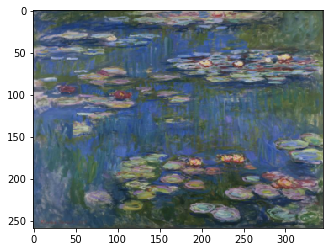

In [77]:
imshow(style)

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device).eval()
content = load_image('janelle3.png').to(device)
# Resize style to match content, makes code easier
style = load_image('Matisse-Woman-with-a-Hat.jpg', shape=content.shape[-2:]).to(device)

# Calculate content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

24485446.0


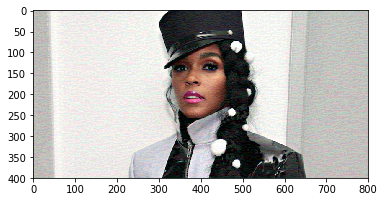

18341820.0


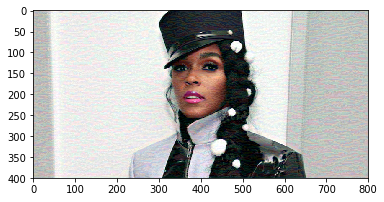

15354686.0


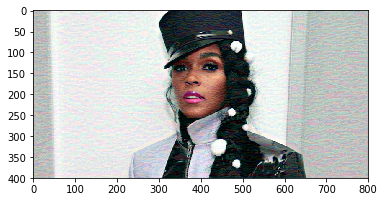

13075186.0


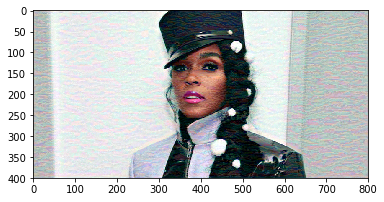

11102508.0


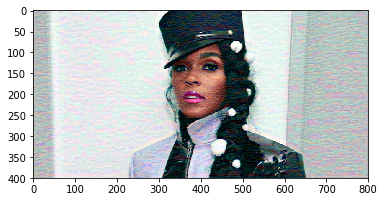

9337922.0


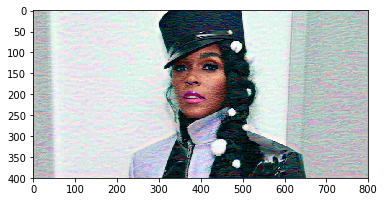

7783150.0


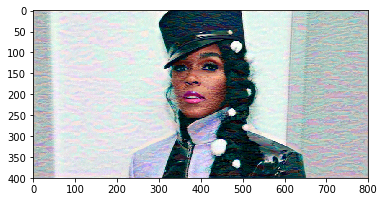

6469400.5


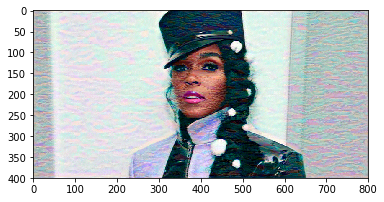

In [ ]:
style_weights = {'conv1_1': 0.2,
                 'conv2_1': 0.2,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

optimizer = optim.Adam([target], lr=0.003)

steps = 4000
content_weight = 1
style_weight = 1e6
tv_weight = 1e-6
show_every = 100

for ii in range(1, steps+1):
    
    style_loss = 0
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # Style loss now
    for layer in style_weights:
        target_feature = target_features[layer]
        _, c, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        style_loss += style_weights[layer] * torch.mean((target_gram - style_gram)**2) / (c * h * w)
        
    # Total variational loss, reduces noise in the image
    diff_i = torch.sum(torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1]))
    diff_j = torch.sum(torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :]))
    tv_loss = (diff_i + diff_j)
    
    total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print(total_loss.item())
        imshow(target)
        plt.show()

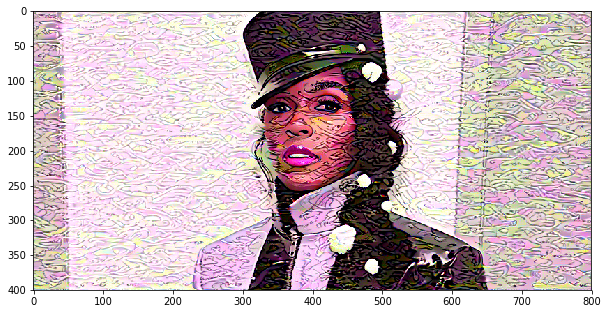

In [93]:
plt.figure(figsize=(10,10))
imshow(target)